In [21]:
!pip install peft transformers torch accelerate #datasets

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorForLanguageModeling, GPT2Tokenizer, GPT2LMHeadModel
from peft import get_peft_model, LoraConfig #, TaskType  # LoRa support

In [22]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
class YouTubeTitlesDatasetV3(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128, transform=None):
        # Load the dataset into a pandas DataFrame
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer  # Tokenizer passed during initialization
        self.max_length = max_length  # Max length for tokenization
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        title = self.data.iloc[idx, 0]  # YouTube video title
        label = self.data.iloc[idx, 1]  # Classification tag (0 or 1)
        sentence = self.data.iloc[idx, 2]  # Sentence including the title

        # Tokenize the sentence
        encodings = self.tokenizer(sentence, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")

        # Return input_ids and attention_mask along with label
        input_ids = encodings['input_ids'].squeeze()  # Tokenized input
        attention_mask = encodings['attention_mask'].squeeze()  # Attention mask

        sample = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


In [24]:
# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=128)

# train_encodings = train_df['sentence'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=128))
# val_encodings = val_df['sentence'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=128))
# test_encodings = test_df['sentence'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=128))

In [25]:
train_dataset = YouTubeTitlesDatasetV3('/content/drive/MyDrive/Deep/GPT2_FT/train_Dataset_v3.csv', tokenizer)
val_dataset = YouTubeTitlesDatasetV3('/content/drive/MyDrive/Deep/GPT2_FT/val_Dataset_v3.csv', tokenizer)
test_dataset = YouTubeTitlesDatasetV3('/content/drive/MyDrive/Deep/GPT2_FT/test_Dataset_v3.csv', tokenizer)

In [ ]:
# version with early stopping in case need to run train again

def train(model, train_dataloader, val_dataloader, device, batch_size=4, num_epochs=3, learning_rate=2e-4, patience=3, checkpoint_dir='checkpoints'):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')  # Best validation loss initialized to infinity
    patience_counter = 0  # Counts how many epochs since improvement

    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        total_loss = 0

        # Progress bar for training
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predictions = outputs.logits.argmax(dim=-1)
            correct += (predictions == input_ids).sum().item()
            total += input_ids.numel()

            avg_loss = total_loss / (progress_bar.n + 1)
            progress_bar.set_postfix({"loss": f"{avg_loss:.4f}"})

        epoch_accuracy = correct / total
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Evaluate on validation set at the end of each epoch
        val_loss = evaluate_loss(model, val_dataloader, device)
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping and checkpoint saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if improvement is seen

            # Save checkpoint (model state and optimizer state)
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
                break

def evaluate_loss(model, eval_dataloader, device):
    model.eval()
    total_loss = 0
    total_batches = len(eval_dataloader)

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    model.train()  # Set the model back to training mode after evaluation
    return avg_loss


In [26]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)

# LoRa
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [27]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2SdpaAttention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lo

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}%"
    )


print_trainable_parameters(model)

trainable params: 589824 || all params: 125029632 || trainable%: 0.47%


##Training

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Train the model with early stopping
train(model, train_dataloader, val_dataloader, device, batch_size=16, num_epochs=30, patience=3)


Epoch [1/30], Loss: 0.5986, Accuracy: 0.7840
Validation Loss: 0.6637
Checkpoint saved at checkpoints/best_model_epoch_1.pt


Epoch [2/30], Loss: 0.5665, Accuracy: 0.7840
Validation Loss: 0.6669


Epoch [3/30], Loss: 0.5545, Accuracy: 0.7840
Validation Loss: 0.6686


Epoch [4/30], Loss: 0.5460, Accuracy: 0.7840
Validation Loss: 0.6576
Checkpoint saved at checkpoints/best_model_epoch_4.pt


Epoch [5/30], Loss: 0.5392, Accuracy: 0.7840
Validation Loss: 0.6748


Epoch [6/30], Loss: 0.5334, Accuracy: 0.7840
Validation Loss: 0.6584


Epoch [7/30], Loss: 0.5284, Accuracy: 0.7840
Validation Loss: 0.6405
Checkpoint saved at checkpoints/best_model_epoch_7.pt


Epoch [8/30], Loss: 0.5247, Accuracy: 0.7839
Validation Loss: 0.6486


Epoch [9/30], Loss: 0.5205, Accuracy: 0.7840
Validation Loss: 0.6417


Epoch [10/30], Loss: 0.5168, Accuracy: 0.7840
Validation Loss: 0.6542
Early stopping triggered. No improvement in validation loss for 3 epochs.


##Load and evaluate trained model

In [ ]:

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Check if CUDA is available and move the model to the GPU if it is, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# LoRa
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

# Load the checkpoint (state_dict)
load_checkpoint = torch.load('/content/drive/MyDrive/Deep/GPT2_FT/trained_model_GPT2_final.pth', map_location=device)
model.load_state_dict(load_checkpoint['model'])
model.pad_token_id = tokenizer.eos_token_id


# Function to generate a response from GPT-2
def generate_response(prompt):
    # Tokenize the input prompt and move it to the same device as the model
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate the output using GPT-2
    outputs = model.generate(inputs, max_length=128, num_return_sequences=1, no_repeat_ngram_size=2,
                             pad_token_id=tokenizer.eos_token_id)

    # Decode the output and return it as a string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Deep/GPT2_FT/test_Dataset_v3.csv')

def expected_output(entry):
  if entry['tags'] == 1:
    return entry['sentence'] + "Gaming and Entertainment."
  else:
    return entry['sentence'] + "Not Gaming and Entertainment."

# add new col of 'expected'
test_data['expected'] = test_data.apply(expected_output, axis=1)
test_data.head()



,title,tags,sentence,expected
0,"Ray J Talks Justin Bieber Beef, Raycon Earbud...",1,"""Ray J Talks Justin Bieber Beef, Raycon Earbu...","""Ray J Talks Justin Bieber Beef, Raycon Earbu..."
1,Gervonta Davis immediately after the Weigh In ...,0,"""Gervonta Davis immediately after the Weigh In...","""Gervonta Davis immediately after the Weigh In..."
2,The First Couple To Ever Move In Together (ft....,0,"""The First Couple To Ever Move In Together (ft...","""The First Couple To Ever Move In Together (ft..."
3,Who is Lolbit? - FNAF Facts #Shorts #FNAF,0,"""Who is Lolbit? - FNAF Facts #Shorts #FNAF"" is...","""Who is Lolbit? - FNAF Facts #Shorts #FNAF"" is..."
4,Kyle Larson Doesn't Hold Back On Contact With ...,0,"""Kyle Larson Doesn't Hold Back On Contact With...","""Kyle Larson Doesn't Hold Back On Contact With..."


In [ ]:
for idx in range(len(test_data)):
  print(test_data['sentence'][idx+1])
  print(test_data['expected'][idx+1])
  break

"Gervonta Davis immediately after the Weigh In | Davis vs Romero" is a title of a video about 
"Gervonta Davis immediately after the Weigh In | Davis vs Romero" is a title of a video about Not Gaming and Entertainment.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, top_k_accuracy_score, f1_score
import pandas as pd
from tqdm import tqdm

# Manually define the label encoding
label_mapping = {
    "Gaming and Entertainment.": 1,
    "Not Gaming and Entertainment.": 0
}

# Helper function to extract the last part of the sentence (label)
def extract_label(sentence):
    if sentence.endswith("Not Gaming and Entertainment."):
        return "Not Gaming and Entertainment."
    elif sentence.endswith("Gaming and Entertainment."):
        return "Gaming and Entertainment."
    else:
        return None  # Handle unexpected labels

def generate_response(prompt, top_k=1):
    # Tokenize the input prompt and move it to the same device as the model
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate multiple output sequences using GPT-2 (up to top_k sequences)
    outputs = model.generate(
        inputs,
        max_length=128,
        num_return_sequences=top_k,  # Generate up to top_k sequences
        no_repeat_ngram_size=2,
        pad_token_id=tokenizer.eos_token_id,
        # do_sample=True,  # Enable sampling to generate diverse sequences
        # top_k=top_k,  # Set top_k sampling
        # temperature=0.7  # Adjust temperature for diversity
    )

    # Decode each of the generated sequences and return as a list of strings
    responses = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return responses  # Return the list of responses

# List to store results
results = []
true_labels = []
predicted_labels_top1 = []  # To store top-1 predictions

# Loop through each row in the test data
for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    input_sentence = row['sentence']
    expected_label = extract_label(row['expected'])  # Extract true label from the sentence

    # Map true labels using the label_mapping
    if expected_label in label_mapping:
        true_labels.append(label_mapping[expected_label])
    else:
        true_labels.append(-1)  # Handle unexpected labels

    # Prepare the input sentence
    prompt = input_sentence[:-1]

    # Generate GPT-2's ranked responses
    ranked_responses = generate_response(prompt)

    # Process the predicted responses and map them to labels
    top1_response = ranked_responses[0]  # Get top-1 response
    top1_label = label_mapping.get(extract_label(top1_response), -1)  # Map to label or -1 for unknown


    # Store top-1 prediction
    predicted_labels_top1.append(top1_label)

    # Append the input sentence, expected label, and GPT-2 response to the results list
    results.append({
        'input': input_sentence,
        'prompt': prompt,
        'label': expected_label,
        'expected': row['expected'],
        'GPT2_top1': top1_response,
        'GPT2_ranked': ranked_responses
    })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Save to a CSV file
df_results.to_csv('/content/drive/MyDrive/Deep/GPT2_FT/gpt2_responses.csv', index=False)
print("Table saved as 'gpt2_responses.csv'.")


100%|██████████| 9695/9695 [11:45<00:00, 13.75it/s]


Table saved as 'gpt2_responses.csv'.


In [ ]:
# Filter valid predictions (i.e., excluding -1 values)
valid_indices = [i for i, val in enumerate(predicted_labels_top1) if val != -1 and true_labels[i] != -1]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels_top1 = [predicted_labels_top1[i] for i in valid_indices]

# Calculate metrics
accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels_top1)
f1 = f1_score(filtered_true_labels, filtered_predicted_labels_top1, average='binary')

# Calculate top-1 accuracy (equivalent to normal accuracy here)
top1_accuracy = accuracy

# Generate the confusion matrix for top-1 predictions
conf_matrix = confusion_matrix(filtered_true_labels, filtered_predicted_labels_top1)

# Print metrics
print(f"Accuracy (Top-1): {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)


Accuracy (Top-1): 79.40%
F1 Score: 0.74
Confusion Matrix:
 [[4871 1018]
 [ 979 2826]]


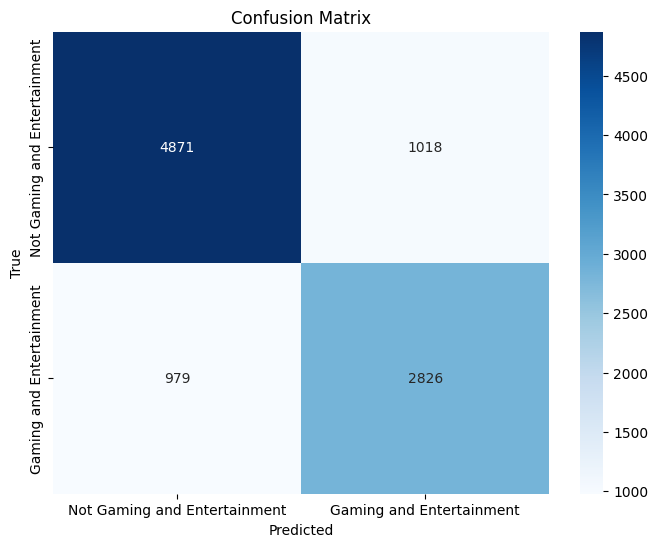

In [ ]:

# Create a heatmap for the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Gaming and Entertainment", "Gaming and Entertainment"], yticklabels=["Not Gaming and Entertainment", "Gaming and Entertainment"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# final results:
print("-"*30)
print("Final Results:")
print(f"\tTop-1 accuracy: {100* accuracy:.2f}%")
print(f"\tPrecision: {100*(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])):.2f}%")
print(f"\tRecall: {100*(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])):.2f}%")
print(f"\tF1 Score: {100*f1:.2f}%")
print("-"*30)

------------------------------
Final Results:
	Top-1 accuracy: 79.40%
	Precision: 73.52%
	Recall: 74.27%
	F1 Score: 73.89%
------------------------------


In [ ]:
# save results and final model
final_scores = {
    'Top-1 Accuracy': 100* accuracy,
    'Precision': 100*(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])),
    'Recall': 100*(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])),
    'F1 Score': 100*f1,
    'Confusion Matrix': conf_matrix
}

saved_data = {'model': model.state_dict(), 'final_results': df_results, 'scores': final_scores}
torch.save(saved_data, '/content/drive/MyDrive/Deep/GPT2_FT/trained_model_GPT2_final.pth')

In [20]:
# Loop to interact with GPT-2 continuously
while True:
    # Get user input
    prompt = input("You: (enter a title)\n")

    # Break the loop if the user types 'exit'
    if prompt.lower() == "exit":
        print("Exiting...")
        break

    prompt = "\"" + prompt + "\" is a title of a video about"

    # Generate and print GPT-2's response
    response = generate_response(prompt)
    print("LoRa:", response[0])

You: (enter a title)
News TODAY | BBC
LoRa: "News TODAY | BBC" is a title of a video about Not Gaming and Entertainment.
You: (enter a title)
Gaming POV
LoRa: "Gaming POV" is a title of a video about Gaming and Entertainment.
You: (enter a title)
Deep Learning
LoRa: "Deep Learning" is a title of a video about Not Gaming and Entertainment.
You: (enter a title)
LoRa Training you deep NN
LoRa: "LoRa Training you deep NN" is a title of a video about Not Gaming and Entertainment.
You: (enter a title)
Basic Integrals
LoRa: "Basic Integrals" is a title of a video about Not Gaming and Entertainment.
You: (enter a title)
GTA V killing them all
LoRa: "GTA V killing them all" is a title of a video about Gaming and Entertainment.
You: (enter a title)
VLSI timing analysis
LoRa: "VLSI timing analysis" is a title of a video about Not Gaming and Entertainment.
You: (enter a title)
exit
Exiting...
